## Постановка задачи

Написать программу вычисления матричного выражения:

$\mathbf{A} = \mathbf{B}\ \mathbf{C}^2 + M(\mathbf{C})\ \mathbf{I} + \mathbf{I} + D(\mathbf{B})\ \mathbf{E}$,

где $\mathbf{B}$, $\mathbf{C}$ – квадратные плотные матрицы, элементы которых имеют тип double, причем элементы матрицы $\mathbf{C}$ задаются с помощью генератора псевдослучайных чисел, $\mathbf{I}$ – единичная матрица, $\mathbf{E}$ – полностью заполненная матрица, все элементы которой равны единице, $M(\mathbf{C)}$ – среднее значений элементов матрицы $\mathbf{C}$, $D(\mathbf{C)}$ – дисперсия элементов матрицы $\mathbf{C}$. Распараллелить эту программу с помощью MPI (Message Passing Interface). Исследовать зависимость масштабируемости параллельной версии программы от ее вычислительной трудоемкости (размера матриц).  
Проверить корректность параллельной версии.  
Проверка закона Амдала. Построить зависимость ускорение:число процессов для заданного примера.

## Программно-аппаратная конфигурация тестового стенда

Информация о программно-аппаратной конфигурации тестового стенда была получена c помощью следующего shell-скрипта:

```sh
echo -n "OS: "; cat /etc/os-release | grep PRETTY_NAME \
     | cut -d= -f2 | tr -d '"'
echo -n "GCC Version: "; gcc --version | head -n 1
echo -n "CPU Model: "; lscpu | grep "Model name" \
     | awk -F: '{print $2}' | xargs
echo -n "Logical Cores: "; lscpu | grep "^CPU(s):" \
     | awk -F: '{print $2}' | xargs
echo -n "RAM: "; free -h --si | awk '/Mem:/ {print $2}'
```

Результат работы скрипта получения программно-аппаратной конфигурации:

In [1]:
!echo -n "OS: "; cat /etc/os-release | grep PRETTY_NAME \
     | cut -d= -f2 | tr -d '"'
!echo -n "MPICC Version: "; mpicc --version | head -n 1
!echo -n "CPU Model: "; lscpu | grep "Model name" \
     | awk -F: '{print $2}' | xargs
!echo -n "Logical Cores: "; lscpu | grep "^CPU(s):" \
     | awk -F: '{print $2}' | xargs
!echo -n "Physical Cores: "; lscpu \
     | grep "^Core(s) per socket:" \
     | awk -F: '{print $2}' | xargs
!echo -n "RAM: "; free -h --si | awk '/Mem:/ {print $2}'

OS: Ubuntu 22.04.4 LTS
MPICC Version: gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
CPU Model: 13th Gen Intel(R) Core(TM) i7-13700H
Logical Cores: 20
Physical Cores: 14
RAM: 31G


Также стоит отметить, что среди ядер процессора i7-13700H можно выделить шесть производительных и восемь эффективных. 

## Метод

Алгоритм решения:

- вычисление $m = M(\mathbf{C})$;
- вычисление $d = D(\mathbf{B})$;
- вычисление $\mathbf{BC} = \mathbf{B}\ \mathbf{C}$;
- вычисление $\mathbf{BCC} = \mathbf{BC}\ \mathbf{C}$;
- прибавление $1 + m$ к каждому элементу главной диагонали $\mathbf{BCC}$;
- прибавление $d$ к каждому элементу полученной на предыдущем шаге матрицы.

Для вычисления произведения матриц используется наивный алгоритм, основанный на определении произведения матриц $(\mathbf{A}\ \mathbf{B})_{i,j} = \sum_{k=1}^n \mathbf{A}_{i,k}\ \mathbf{B}^T_{j,k}$. Правый множитель транспонируется перед вычислением произведения, чтобы эффективнее использовать кэши процессора.

## Реализация

Решение реализовано на языке программирования C и находится в приложении к данному отчёту. Также в разделе "Приложение" находится make-файл, используемый для сборки двух исполняемых файлов:

- `main` – решает поставленную задачу;
- `save_random_matrix` – генерирует псевдослучайные квадратные матрицы указанного размера.

Для распараллеливания умножений матриц используется MPI:

- строки матрицы $\mathbf{B}$ поровну распределяются между процессами, то есть $k$-ый процесс получает матрицу $\mathbf{B}_k$, содержащую строки матрицы $\mathbf{B}$, соответствующие интервалу, выделенному $k$-му процессу;
- каждый процесс вычисляет матрицу $\mathbf{BCC}_k = (\mathbf{B}_k\ \mathbf{C})\ \mathbf{C}$, содержащую строки матрицы $\mathbf{BCC}$, соответствующие интервалу, выделенному $k$-му процессу;
- процессы передают матрицы $\mathbf{BCC}_k$ процессу с рангом $0$, который собирает из матриц $\mathbf{BCC}_k$ матрицу $\mathbf{BCC}$.

## Эксперимент

В данном разделе приведены результаты экспериментов, призванных ответить на три исследовательских вопроса:

1. Корректно ли разработанная реализация работает в параллельном режиме?
2. Как разработанная реализация масштабируется при увеличении размера матриц?
3. Выполняется ли для разработанной реализации закон Амдала?

### Корректность

Сначала была проверена корректность работы последовательной версии программы на следующих небольших матрицах $\mathbf{B}$ и $\mathbf{C}$ размера $2 \times 2$, правильный ответ для которых был посчитан вручную:

$$
\mathbf{B} = \begin{bmatrix} 1 & 2 \\ 3 & 4 \end{bmatrix}, \quad
\mathbf{C} = \begin{bmatrix} 5 & 6 \\ 7 & 8 \end{bmatrix},
$$
$$
M(\mathbf{C}) = 6.5, \quad D(\mathbf{B}) = 1.25,
$$
$$
\mathbf{A} = \mathbf{B} \cdot \mathbf{C}^2 + M(\mathbf{C}) \cdot \mathbf{I} + \mathbf{I} + D(\mathbf{B}) \cdot \mathbf{E},
$$
$$
\mathbf{A} = \begin{bmatrix} 257.75 & 291.25 \\ 566.25 & 666.75 \end{bmatrix}.
$$


In [ ]:
%pip install matplotlib
%pip install nbconvert
%pip install pandas
%pip install scipy
%pip install tabulate
%pip install numpy==1.24.4

In [3]:
import subprocess
import re
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import filecmp

from getpass import getpass
from IPython.display import Markdown, display
from scipy.optimize import curve_fit

In [ ]:
subprocess.run(['make'], check=True)

Для проверки соответствия результатов работы последовательной версии программы результатам, полученным вручную, использовался следующий Python-скрипт:

```python
subprocess.run(
    [
        './main',
        'data/B_sample.txt',
        'data/C_sample.txt',
        'data/A_sample_actual.txt',
    ],
    stdout=subprocess.PIPE, text=True, check=True
)
actual_path = "data/A_sample_actual.txt"
expected_path = "data/A_sample_expected.txt"

print(f"'{actual_path}' file content:")
!cat {actual_path} 

if (filecmp.cmp(actual_path, expected_path)):
    print("Seqential version results match manual results")
else:
    print("Seqential and manual results diverged!")
```

Далее приведён результат работы скрипта проверки корректности последовательной версии программы на рассмотренном примере:

In [5]:
subprocess.run(
    [
        './main',
        'data/B_sample.txt',
        'data/C_sample.txt',
        'data/A_sample_actual.txt',
    ],
    stdout=subprocess.PIPE, text=True, check=True
)
actual_path = "data/A_sample_actual.txt"
expected_path = "data/A_sample_expected.txt"

print(f"'{actual_path}' file content:")
!cat {actual_path} 

if (filecmp.cmp(actual_path, expected_path)):
    print("Seqential version results match manual results")
else:
    print("Seqential and manual results diverged!")

'data/A_sample_actual.txt' file content:
2
257.750000 291.250000 
566.250000 666.750000 
Seqential version results match manual results


После этого был запущен следующий Python-скрипт, генерирующий псевдослучайные матрицы размера $3000 \times 3000$ и сверяющий для этих матриц результаты работы последовательной и параллельной версий программы (реализацию функции `run_experiment` можно найти в разделе "Приложение").

```python
_, _, seq_output = run_experiment(matrix_size=3000, num_procs=1)
_, _, par_output = run_experiment(matrix_size=3000, num_procs=12)
if (filecmp.cmp(seq_output, par_output)):
    print("Parallel and sequential results match")
else:
    print("Parallel and sequential results diverge!")
```

Далее приведён результат работы данного скрипта:

In [6]:
def run_experiment(
        matrix_size,
        num_procs,
        seed=42,
        min_value=-1.0,
        max_value=1.0,
        reruns = 5,
        data_dir = 'data'
):
    """
    Returns the following triple:
      (mean_time, time_std, path_to_output_file)
    """
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    B_filename = os.path.join(data_dir, f'B_{matrix_size}.txt')
    C_filename = os.path.join(data_dir, f'C_{matrix_size}.txt')
    A_filename = os.path \
        .join(data_dir, f'A_{matrix_size}_{num_procs}.txt')
    
    subprocess.run(['./save_random_matrix', B_filename, \
                    str(matrix_size), str(min_value), \
                    str(max_value), str(seed)], check=True)
    
    subprocess.run(['./save_random_matrix', C_filename, \
                    str(matrix_size), str(min_value), \
                    str(max_value), str(seed+1)], check=True)
    
    times = []

    for _ in range(reruns):
        result = subprocess.run(['mpirun', '-n', str(num_procs), \
                                 'main', B_filename, C_filename, \
                                 A_filename], \
                                stdout=subprocess.PIPE, text=True)
        match = re.search(r'Computation time: ([\d\.]+) seconds', \
                          result.stdout)
        if match:
            times.append(float(match.group(1)))
        else:
            raise RuntimeError("Failed to extract computation time")
        
    return np.mean(times), np.std(times, ddof=1), A_filename

In [7]:
_, _, seq_output = run_experiment(matrix_size=3000, num_procs=1)
_, _, par_output = run_experiment(matrix_size=3000, num_procs=12)
if (filecmp.cmp(seq_output, par_output)):
    print("Parallel and sequential results match")
else:
    print("Parallel and sequential results diverge!")

Parallel and sequential results match


### Масштабируемость

Здесь и далее время работы указывается без учёта времени генерации входных данных и времени, затраченного на операции ввода-вывода, но с учётом времени, затраченного на коммуникацию между процессами.

Для оценки масштабируемости программы от её вычислительной трудоемкости (размера матриц) был выполнен следующий Python-скрипт:
```python
sizes = list(range(2000, 7000, 600))
num_procs = 6

mean_times_for_sizes = []
stds_for_sizes = []
for size in sizes:
    mean_time, time_std, _ = run_experiment(size, num_procs)
    mean_times_for_sizes.append(mean_time)
    stds_for_sizes.append(time_std)

mean_time_plus_minus_std = [
    f"{mean:.2f} ± {std:.2f}" 
    for mean, std in zip(mean_times_for_sizes, stds_for_sizes)
]

pd.DataFrame({
    'N': sizes,
    'Time ± std (seconds)': mean_time_plus_minus_std
}).round(2)
```

В результате работы скрипта была построена следующая таблица, показывающая как время работы параллельной версии программы для матриц размера $N \times N$ увеличивается с ростом $N$ при использовании 6 процессов (после <<$\pm$>> указывается выборочное стандартное отклонение по результатам пяти замеров):

In [ ]:
sizes = list(range(2000, 7000, 600))
num_procs = 6

mean_times_for_sizes = []
stds_for_sizes = []
for size in sizes:
    mean_time, time_std, _ = run_experiment(size, num_procs)
    mean_times_for_sizes.append(mean_time)
    stds_for_sizes.append(time_std)
    print(f"N: {size}, time: {mean_time:.6f} +- {time_std:.6f} seconds")

In [9]:
mean_time_plus_minus_std = [
    f"{mean:.2f} ± {std:.2f}" 
    for mean, std in zip(mean_times_for_sizes, stds_for_sizes)
]

display(Markdown(pd.DataFrame({
    'N': sizes,
    'Time ± std (seconds)': mean_time_plus_minus_std
}).round(2).to_markdown(index=False)))

|    N | Time ± std (seconds)   |
|-----:|:-----------------------|
| 2000 | 2.38 ± 0.01            |
| 2600 | 5.24 ± 0.03            |
| 3200 | 9.90 ± 0.03            |
| 3800 | 16.63 ± 0.06           |
| 4400 | 25.98 ± 0.07           |
| 5000 | 38.32 ± 0.02           |
| 5600 | 54.47 ± 0.46           |
| 6200 | 75.16 ± 0.88           |
| 6800 | 102.28 ± 1.49          |

Также по данной таблице был построен следующий график, более наглядно показывающий связь размера матрицы $N$ и времени работы:

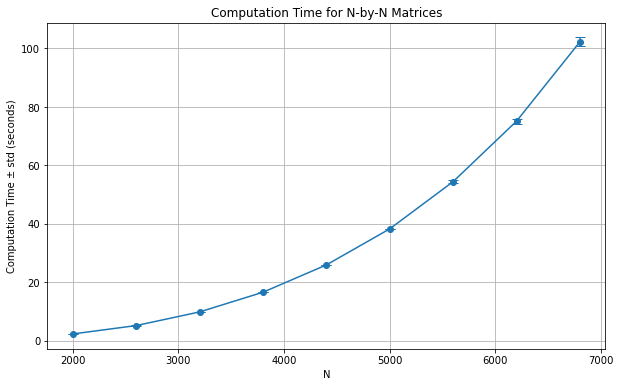

In [10]:
plt.figure(figsize=(10,6))

plt.errorbar(sizes, mean_times_for_sizes, yerr=stds_for_sizes, fmt='o-', capsize=5)
plt.title('Computation Time for N-by-N Matrices')
plt.xlabel('N')
plt.ylabel('Computation Time ± std (seconds)')
plt.grid(True)

plt.show()

С помощью следующего Python-скрипта был определён коэффициент наклона прямой, отражающей зависимость времени работы программы от размера задачи в логарифмическом масштабе.

```python
slope, _ = np.polyfit(np.log(sizes), np.log(mean_times_for_sizes), deg=1)
print(f"Slope on a log-log plot: {slope:.2f}")
```

В результате выполнения скрипта была получена следующая оценка угла наклона, соответствующая степени экспоненты в зависимости времени выполнения от размера задачи:

In [11]:
slope, _ = np.polyfit(np.log(sizes), np.log(mean_times_for_sizes), deg=1)
print(f"Slope on a log-log plot: {slope:.2f}")

Slope on a log-log plot: 3.06


### Проверка закона Амдала

Для оценки зависимости времени работы от числа процессов и проверки закона Амдала был выполнен следующий Python-скрипт:

```python
matrix_size = 3000
max_procs = 14

procs_list = list(range(1, max_procs+1))
times_for_procs = []

for num_procs in procs_list:
    time, _, _ = run_experiment(matrix_size, num_procs)
    times_for_procs.append(time)

base_time = times_for_procs[0]
speedups = [base_time / t for t in times_for_procs]

def amdahl_law(N, P):
    return 1 / ((1 - P) + P / N)

params, _ = curve_fit(amdahl_law, procs_list[:6], speedups[:6], bounds=(0, 1))
parallel_part = params[0]

predicted_speedups = [amdahl_law(N, parallel_part) for N in procs_list]

pd.DataFrame({
    'Number of Processes': procs_list,
    'Measured Speedup': speedups,
    f"Amdahl's law (P={parallel_part:.4f})": predicted_speedups
}).round(2)
```

В следующее таблицы приведены средние ускорения по результатам пяти замеров для матриц размера $3000 \times 3000$. Также в таблице для каждого рассмотренного числа процессов указано ускорение, предсказываемое законом Амдала для значения параметра $P$, минимизирующего среднеквадратичную ошибку законом Амдала для тех случаев, когда число процессов не больше числа производительных ядер процессора.

In [ ]:
matrix_size = 3000
max_procs = 14

procs_list = list(range(1, max_procs+1))
times_for_procs = []

for num_procs in procs_list:
    time, _, _ = run_experiment(matrix_size, num_procs)
    times_for_procs.append(time)
    print(f'Number of threads: {num_procs}, time: {time:.6f} seconds')

In [13]:
base_time = times_for_procs[0]
speedups = [base_time / t for t in times_for_procs]

def amdahl_law(N, P):
    return 1 / ((1 - P) + P / N)

params, _ = curve_fit(amdahl_law, procs_list[:6], speedups[:6], bounds=(0, 1))
parallel_part = params[0]

predicted_speedups = [amdahl_law(N, parallel_part) for N in procs_list]

display(Markdown(pd.DataFrame({
    'Number of Processes': procs_list,
    'Measured Speedup': speedups,
    f"Amdahl's law (P={parallel_part:.4f})": predicted_speedups
}).round(2).to_markdown(index=False)))

|   Number of Processes |   Measured Speedup |   Amdahl's law (P=0.9182) |
|----------------------:|-------------------:|--------------------------:|
|                     1 |               1    |                      1    |
|                     2 |               1.95 |                      1.85 |
|                     3 |               2.8  |                      2.58 |
|                     4 |               3.22 |                      3.21 |
|                     5 |               3.73 |                      3.77 |
|                     6 |               4.2  |                      4.26 |
|                     7 |               3.02 |                      4.7  |
|                     8 |               3.29 |                      5.09 |
|                     9 |               3.18 |                      5.44 |
|                    10 |               3.47 |                      5.76 |
|                    11 |               3.49 |                      6.05 |
|                    12 |               3.62 |                      6.32 |
|                    13 |               3.83 |                      6.56 |
|                    14 |               3.9  |                      6.79 |

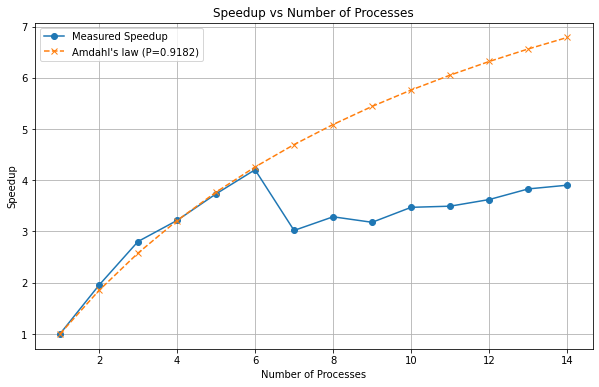

In [14]:
plt.figure(figsize=(10,6))
plt.plot(procs_list, speedups, marker='o', label='Measured Speedup')
plt.plot(procs_list, predicted_speedups, marker='x', linestyle='--', label=f"Amdahl's law (P={parallel_part:.4f})")
plt.title('Speedup vs Number of Processes')
plt.xlabel('Number of Processes')
plt.ylabel('Speedup')
plt.legend()
plt.grid(True)
plt.show()

## Выводы

Эмпирическим путём установлено, что:

- параллельная реализация работает корректно на рассмотренном примере;
- время работы параллельной реализации при увеличении размера матрицы $N \times N$ растёт примерно пропорционально $N^{3.06}$;
- закон Амдала выполняется для $P=0.92$, когда число процессов меньше либо равно 6.

Объяснение расхождений с теорией:

- расхождение с теоретической оценкой сложности $\mathcal{O}(N^3)$ объясняется конечностью размера кэшей-процессора: с ростом размера матрицы всё меньшая часть матрицы помещается в кэши, что приводит к замедлению реализации;
- невыполнение закона Амдала при использовании более чем 6 процессов объяснятся тем, что, начиная с 7 процессов, начинают использоваться не только производительные, но и эффективные ядра процессора i7-13700H, что плохо сочетается с равномерным распределением строк матрицы $\mathbf{B}$ между процессами;
- наблюдаемая на практике доля параллельных вычислений $P=0.92$ существенно меньше $1$, так как процессы конкурируют за общий L3-кэш и общие модули ОЗУ.

## Приложение

Листинг 1: Файл `src/main.c` --- реализация алгоритма вычисления $\mathbf{A} = \mathbf{B}\ \mathbf{C}^2 + M(\mathbf{C})\ \mathbf{I} + \mathbf{I} + D(\mathbf{B})\ \mathbf{E}$.
```c
#include <stdio.h>
#include <stdlib.h>
#include <mpi.h>
#include <string.h>
#include "matrix_utils.h"

void print_help() {
    printf("Computes and saves "
        "A = B * C^2 + M(C) * I + I + D(B) * E\n"
        "Usage: ./main <B_matrix_file> <C_matrix_file> "
        "<output_A_matrix_file>\n"
        "Matrix file for N-by-N matrix should be in the "
        "following format:\n"
        "First line: N\n"
        "Next N lines: each line contains N space-separated "
        "double values\n");
}

int main(int argc, char *argv[]) {
    MPI_Init(&argc, &argv);

    int rank, size;
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
    MPI_Comm_size(MPI_COMM_WORLD, &size);

    if (argc != 4) {
        if (rank == 0) print_help();
        MPI_Finalize();
        return EXIT_FAILURE;
    }

    const char *B_filename = argv[1];
    const char *C_filename = argv[2];
    const char *A_filename = argv[3];
    
    Matrix *B = NULL;
    Matrix *C = NULL;
    Matrix *C_transposed = NULL;
    double M_C = 0.0;
    double D_B = 0.0;
    int n = 0;

    if (rank == 0) {
        B = read_square_matrix(B_filename);
        C = read_square_matrix(C_filename);

        if (B->nrows != C->nrows) {
            fprintf(stderr, "Matrix sizes do not match.\n");
            free_matrix(B);
            free_matrix(C);
            MPI_Abort(MPI_COMM_WORLD, 1);
        }
    }

    double start_time = 0.0;
    if (rank == 0) {
        start_time = MPI_Wtime();
        
        C_transposed = transpose_matrix(C);
        n = B->nrows;
        M_C = compute_mean(C);
        D_B = compute_variance(B);
    }

    MPI_Bcast(&n, 1, MPI_INT, 0, MPI_COMM_WORLD);

    if (rank != 0) {
        C_transposed = allocate_matrix(n, n);
    }

    MPI_Bcast(
        C_transposed->data, n*n, MPI_DOUBLE,
        0, MPI_COMM_WORLD
    );

    Matrix *B_local = scatter_rows(B, MPI_COMM_WORLD, 0);

    Matrix *BC_local = 
        multiply_by_transposed(B_local, C_transposed);

    Matrix *BCC_local = 
        multiply_by_transposed(BC_local, C_transposed);

    Matrix *result = gather_rows(BCC_local, MPI_COMM_WORLD, 0, n);

    if (rank == 0) {
        add_scalar_to_diagonal(result, M_C + 1.0);
        add_scalar_to_all_elements(result, D_B);

        double end_time = MPI_Wtime();
        double computation_time = end_time - start_time;
        printf("Computation time: %f seconds\n", computation_time);

        write_square_matrix(A_filename, result);
    }

    free_matrix(B);
    free_matrix(C);
    free_matrix(B_local);
    free_matrix(BC_local);
    free_matrix(BCC_local);
    free_matrix(result);

    MPI_Finalize();
    return EXIT_SUCCESS;
}
```

Листинг 2: Файл `src/save_random_matrix.c` --- реализация генерации случайных квадратные матриц.
```c
#include <stdio.h>
#include <stdlib.h>
#include <time.h>
#include "matrix_utils.h"

void print_help() {
    printf("Saves random N-by-N matrix\n"
           "Usage: ./save_random_matrix <output_matrix_file> <N> "
           "<min_value> <max_value> <seed>\n");
}

int main(int argc, char *argv[]) {
    if (argc != 6) {
        print_help();
        return EXIT_FAILURE;
    }

    const char *output_filename = argv[1];
    int n = atoi(argv[2]);
    double min_value = atof(argv[3]);
    double max_value = atof(argv[4]);
    int seed = atoi(argv[5]);

    srand(seed);

    Matrix *matrix = allocate_matrix(n, n);

    for (int i = 0; i < n * n; ++i) {
        double r = ((double)rand() / RAND_MAX);
        matrix->data[i] = min_value + r * (max_value - min_value);
    }

    write_square_matrix(output_filename, matrix);

    free_matrix(matrix);

    return EXIT_SUCCESS;
}
```

Листинг 3: Файл `src/matrix_utils.h` --- заголовочный файл, определяющий функции для работы с матрицами.
```c
#ifndef MATRIX_UTILS_H
#define MATRIX_UTILS_H

#include <mpi.h>
#include <stdio.h>
#include <stdlib.h>

typedef struct {
    int nrows;
    int ncols;
    double *data;
} Matrix;

static inline double matrix_get(
    const Matrix *matrix, int row, int col
) {
    return matrix->data[row * matrix->ncols + col];
}

static inline void matrix_set(
    Matrix *matrix, int row, int col, double value
) {
    matrix->data[row * matrix->ncols + col] = value;
}

Matrix* allocate_matrix(int nrows, int ncols);
void free_matrix(Matrix *matrix);
Matrix* read_square_matrix(const char *filename);
int write_square_matrix(const char *filename, const Matrix *matrix);
double compute_mean(const Matrix *matrix);
double compute_variance(const Matrix *matrix);
Matrix* transpose_matrix(const Matrix *matrix);

Matrix* multiply_by_transposed(
    const Matrix *A, const Matrix *B_transposed
);

void add_scalar_to_diagonal(Matrix *matrix, double scalar);
void add_scalar_to_all_elements(Matrix *matrix, double scalar);

Matrix* scatter_rows(Matrix *matrix, MPI_Comm comm, int root);

Matrix* gather_rows(
    Matrix *local_matrix, MPI_Comm comm, int root, int global_nrows
);

#endif // MATRIX_UTILS_H
```

Листинг 4: Файл `src/matrix_utils.c` --- реализации функций для работы с матрицами.
```c
#include "matrix_utils.h"
#include <assert.h>
#include <mpi.h>

Matrix* allocate_matrix(int nrows, int ncols) {
    Matrix *matrix = (Matrix*)malloc(sizeof(Matrix));
    matrix->nrows = nrows;
    matrix->ncols = ncols;
    matrix->data = (double*) malloc(nrows * ncols * sizeof(double));
    return matrix;
}

void free_matrix(Matrix *matrix) {
    if (matrix) {
        free(matrix->data);
        free(matrix);
    }
}

Matrix* read_square_matrix(const char *filename) {
    FILE *fp = fopen(filename, "r");
    if (!fp) {
        perror("Failed to open matrix file");
        MPI_Abort(MPI_COMM_WORLD, 1);
    }
    int size;
    if (fscanf(fp, "%d", &size) == EOF) {
        fprintf(stderr, "Failed to read matrix size");
        MPI_Abort(MPI_COMM_WORLD, 1);
    }
    Matrix *matrix = allocate_matrix(size, size);
    for (int i = 0; i < size; ++i) {
        for (int j = 0; j < size; ++j) {
            double value;
            if (fscanf(fp, "%lf", &value) == EOF) {
                fprintf(
                    stderr,
                    "Failed to read matrix element at pos (%d, %d)",
                    i, j
                );
                MPI_Abort(MPI_COMM_WORLD, 1);
            }
            matrix_set(matrix, i, j, value);
        }
    }
    fclose(fp);
    return matrix;
}

int write_square_matrix(const char *filename, const Matrix *matrix) {
    FILE *fp = fopen(filename, "w");
    if (!fp) {
        perror("Failed to write matrix file");
        return -1;
    }
    fprintf(fp, "%d\n", matrix->nrows);
    for (int i = 0; i < matrix->nrows; ++i) {
        for (int j = 0; j < matrix->ncols; ++j) {
            fprintf(fp, "%.6f ", matrix_get(matrix, i, j));
        }
        fprintf(fp, "\n");
    }
    fclose(fp);
    return 0;
}

double compute_mean(const Matrix *matrix) {
    double sum = 0.0;
    int total_elements = matrix->nrows * matrix->ncols;
    for (int i = 0; i < total_elements; i++) {
        sum += matrix->data[i];
    }
    return sum / total_elements;
}

double compute_variance(const Matrix *matrix) {
    double mean = compute_mean(matrix);
    double variance = 0.0;
    int total_elements = matrix->nrows * matrix->ncols;
    for (int i = 0; i < total_elements; i++) {
        double diff = matrix->data[i] - mean;
        variance += diff * diff;
    }
    return variance / total_elements;
}

Matrix* transpose_matrix(const Matrix *matrix) {
    Matrix *B_T = allocate_matrix(matrix->ncols, matrix->nrows);
    for (int i = 0; i < matrix->nrows; ++i) {
        for (int j = 0; j < matrix->ncols; ++j) {
            matrix_set(B_T, j, i, matrix_get(matrix, i, j));
        }
    }
    return B_T;
}

Matrix* multiply_by_transposed(
    const Matrix *A, const Matrix *B_transposed
) {
    assert(A->ncols == B_transposed->ncols);
    Matrix *result = allocate_matrix(A->nrows, B_transposed->nrows);

    for (int i = 0; i < A->nrows; i++) {
        for (int j = 0; j < B_transposed->nrows; j++) {
            double sum = 0.0;
            for (int k = 0; k < A->ncols; k++) {
                sum += matrix_get(A, i, k) 
                    * matrix_get(B_transposed, j, k);
            }
            matrix_set(result, i, j, sum);
        }
    }
    return result;
}

void add_scalar_to_diagonal(Matrix *matrix, double scalar) {
    for (int i = 0; i < matrix->nrows; ++i) {
        double value = matrix_get(matrix, i, i);
        matrix_set(matrix, i, i, value + scalar);
    }
}

void add_scalar_to_all_elements(Matrix *matrix, double scalar) {
    int total = matrix->nrows * matrix->ncols;
    for (int i = 0; i < total; i++) {
        matrix->data[i] += scalar;
    }
}

void calculate_counts_and_displacements(
    int global_nrows, int ncols, int size, int **counts, int **displs
) {
    *counts = (int *) malloc(size * sizeof(int));
    *displs = (int *) malloc(size * sizeof(int));
    int base_rows = global_nrows / size;
    int remainder = global_nrows % size;
    int offset = 0;

    for (int i = 0; i < size; ++i) {
        (*counts)[i] = (i < remainder ? base_rows + 1 : base_rows) 
                          * ncols;
        (*displs)[i] = offset;
        offset += (*counts)[i];
    }
}

Matrix* scatter_rows(Matrix *matrix, MPI_Comm comm, int root) {
    int rank, size, global_nrows, ncols;
    MPI_Comm_rank(comm, &rank);
    MPI_Comm_size(comm, &size);

    if (rank == root) {
        global_nrows = matrix->nrows;
        ncols = matrix->ncols;
    }
    MPI_Bcast(&global_nrows, 1, MPI_INT, root, comm);
    MPI_Bcast(&ncols, 1, MPI_INT, root, comm);

    int base_rows = global_nrows / size;
    int remainder = global_nrows % size;
    int local_nrows = (rank < remainder) ? base_rows + 1 : base_rows;

    Matrix *local_matrix = allocate_matrix(local_nrows, ncols);

    int *counts = NULL, *displs = NULL;
    if (rank == root) {
        calculate_counts_and_displacements(
            global_nrows, ncols, size, &counts, &displs
        );
    }

    MPI_Scatterv(
        /* sendbuf = */ (rank == root ? matrix->data : NULL),
        /* sendcounts = */ counts,
        /* displs = */ displs,
        /* sendtype = */ MPI_DOUBLE,
        /* recvbuf = */ local_matrix->data,
        /* recvcount = */ local_nrows * ncols,
        /* recvtype = */ MPI_DOUBLE,
        /* root = */ root,
        /* comm = */ comm
    );

    if (rank == root) {
        free(counts);
        free(displs);
    }

    return local_matrix;
}

Matrix* gather_rows(
    Matrix *local_matrix, MPI_Comm comm, int root, int global_nrows
) {
    int rank, size, ncols;
    MPI_Comm_rank(comm, &rank);
    MPI_Comm_size(comm, &size);

    ncols = local_matrix->ncols;

    int *counts = NULL, *displs = NULL;
    if (rank == root) {
        calculate_counts_and_displacements(
            global_nrows, ncols, size, &counts, &displs
        );
    }

    Matrix *global_matrix = NULL;
    if (rank == root) {
        global_matrix = allocate_matrix(global_nrows, ncols);
    }

    MPI_Gatherv(
        /* sendbuf = */ local_matrix->data,
        /* sendcount = */ local_matrix->nrows * ncols,
        /* sendtype = */ MPI_DOUBLE,
        /* recvbuf = */ (rank == root ? global_matrix->data : NULL),
        /* recvcounts = */ counts,
        /* displs = */ displs,
        /* recvtype = */ MPI_DOUBLE,
        /* root = */ root,
        /* comm = */ comm
    );

    if (rank == root) {
        free(counts);
        free(displs);
    }

    return global_matrix;
}
```

Листинг 5: Файл `Makefile` --- файл с правилами автоматической сборки проекта, используемый утилитой `make`.
```makefile
CC = mpicc
CFLAGS = -O3

all: main save_random_matrix

main: src/main.c src/matrix_utils.c
	$(CC) $(CFLAGS) -o main src/main.c src/matrix_utils.c

save_random_matrix: src/save_random_matrix.c src/matrix_utils.c
	$(CC) $(CFLAGS) -o save_random_matrix src/save_random_matrix.c \
		src/matrix_utils.c

clean:
	rm -f main save_random_matrix
```


Листинг 6: Python-функция `run_experiment`, используемая для проведения замеров.
```python
def run_experiment(
        matrix_size,
        num_procs,
        seed=42,
        min_value=-1.0,
        max_value=1.0,
        reruns = 5,
        data_dir = 'data'
):
    """
    Returns the following triple:
      (mean_time, time_std, path_to_output_file)
    """
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    B_filename = os.path.join(data_dir, f'B_{matrix_size}.txt')
    C_filename = os.path.join(data_dir, f'C_{matrix_size}.txt')
    A_filename = os.path \
        .join(data_dir, f'A_{matrix_size}_{num_procs}.txt')
    
    subprocess.run(['./save_random_matrix', B_filename, \
                    str(matrix_size), str(min_value), \
                    str(max_value), str(seed)], check=True)
    
    subprocess.run(['./save_random_matrix', C_filename, \
                    str(matrix_size), str(min_value), \
                    str(max_value), str(seed+1)], check=True)
    
    times = []

    for _ in range(reruns):
        result = subprocess.run(['mpirun', '-n', str(num_procs), \
                                 'main', B_filename, C_filename, \
                                 A_filename], \
                                stdout=subprocess.PIPE, text=True)
        match = re.search(r'Computation time: ([\d\.]+) seconds', \
                          result.stdout)
        if match:
            times.append(float(match.group(1)))
        else:
            raise RuntimeError("Failed to extract computation time")
        
    return np.mean(times), np.std(times, ddof=1), A_filename
```

In [ ]:
# Save report, requires pandoc and no special characters in notebook outputs

!jupyter nbconvert --to markdown --no-input experiment.ipynb
!pandoc experiment.md -o report.pdf --pdf-engine=xelatex \
  -V title="Практическая работа \textnumero 2" \
  -V subtitle="Задание A-03 (MPI) \linebreak Методы и технологии высокопроизводительных вычислений I" \
  -V author="Муравьев И.В., группа 24.М71-мм" \
  -V date="\today" \
  -V mainfont="CMU Serif" \
  -V monofont="DejaVu Sans Mono" \
  -V colorlinks=true \
  -V linkcolor=blue \
  -V fontsize=14pt \
  -V documentclass=extarticle \
  -V geometry:margin=1in \
  -V lang=ru-ru \
  -fmarkdown-implicit_figures \
  --highlight-style=tango \
  -V header-includes="\
    \usepackage{titling}"
